In [1]:
import zipfile
with zipfile.ZipFile('./Shaima-asl-signs.zip', 'r') as zip_ref:
    zip_ref.extractall('./images')

In [2]:
%pip install tensorflow
%pip install keras

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import keras

/Users/shaimahaque/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
PATH = './images/images copy/collectedimages'
CLASS_NAMES = ['good', 'help', 'hungry', 'sorry', 'tired']
BATCH_SIZE = 32

Splitting the dataset into train, test and validation

In [5]:
%pip install split-folders

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import splitfolders
import os
print(os.listdir(PATH))

['good', 'tired', 'hungry', 'sorry', 'help']


In [7]:
splitfolders.ratio(PATH,seed=1337, output='Split_Data', ratio=(0.6, 0.2, 0.2))

Prepare the dataset for training

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'Split_Data/train/',
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear'
)

Found 104 files belonging to 5 classes.


In [9]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "Split_Data/val/",
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear'
)

Found 34 files belonging to 5 classes.


In [10]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    "Split_Data/test/",
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear'
)

Found 36 files belonging to 5 classes.


2024-03-14 22:39:46.699516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


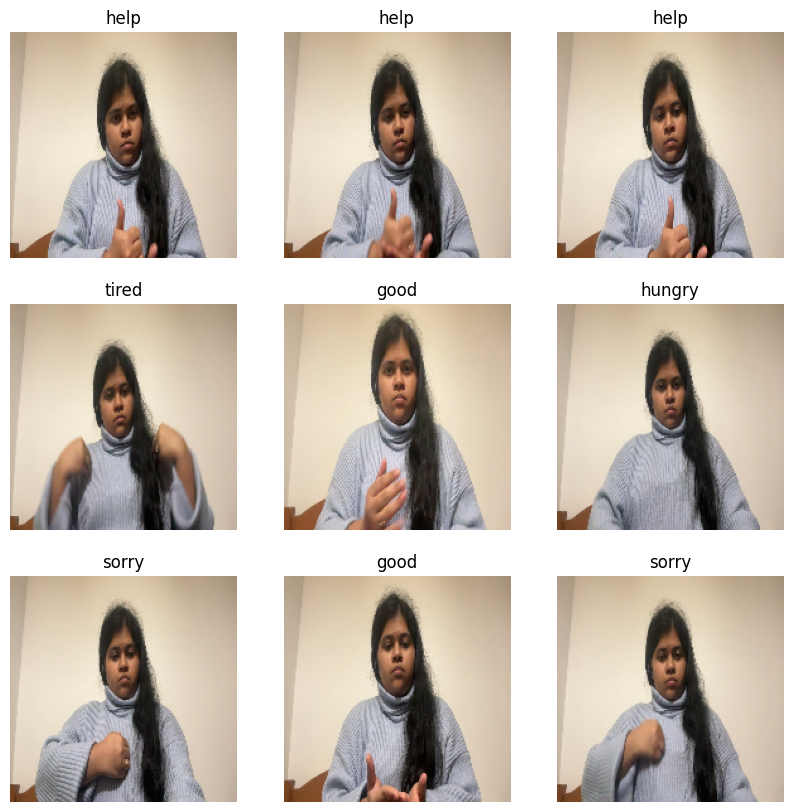

In [11]:
import matplotlib.pyplot as plt

class_names = ['good', 'help', 'hungry', 'sorry', 'tired']
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5)
])

/Users/shaimahaque/Library/Python/3.9/lib/python/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
history = model.fit(
  dataset,
  batch_size=BATCH_SIZE,
  validation_data=validation_dataset,
  epochs=10
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.2406 - loss: 3.1293 - val_accuracy: 0.1765 - val_loss: 2.8627
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.1643 - loss: 2.1045 - val_accuracy: 0.4706 - val_loss: 1.5510
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.3412 - loss: 1.5678 - val_accuracy: 0.2941 - val_loss: 1.4679
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.2783 - loss: 1.4960 - val_accuracy: 0.2941 - val_loss: 1.3002
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.3493 - loss: 1.3519 - val_accuracy: 0.9412 - val_loss: 1.0953
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8954 - loss: 1.1104 - val_accuracy: 0.9706 - val_loss: 0.9178
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9171 - loss: 0.7907 - val_accuracy: 1.0000 - val_loss: 0.5502
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9425 - loss: 0.5163 - val_accuracy: 1.0000 - val_loss:

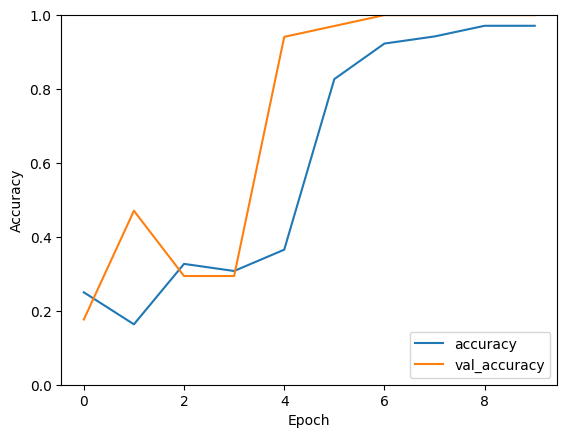

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

Testing


In [17]:
test_accuracy = model.evaluate(test_dataset,steps=624)

624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 51us/step - accuracy: 0.9444 - loss: 0.1016   


2024-03-14 22:40:13.668284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


In [18]:
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import cv2

In [20]:
TEST_IMAGE_PATH = 'images/images copy/collectedimages/tired/tired.c7bc7b7a-bbb6-11ee-83ca-7e09ada021c9.jpg'

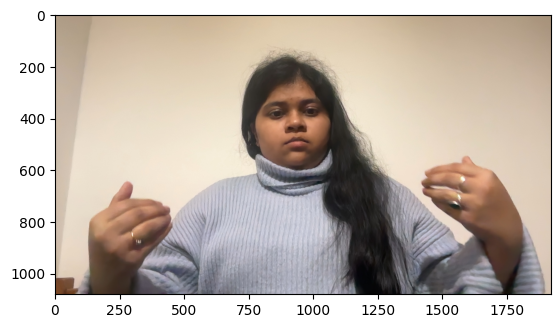

In [21]:
img = cv2.imread(TEST_IMAGE_PATH)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

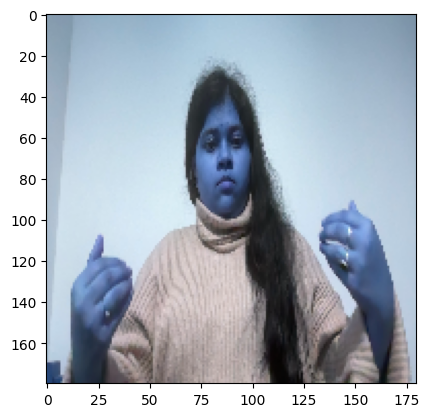

In [22]:
resize = tf.image.resize(img, (180,180))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [23]:
import numpy as np
from keras import models

In [65]:
model = models.load_model('cnn_10ep_ac1_Shaima.h5')

In [24]:
prediction = model.predict(np.expand_dims(resize, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


In [25]:
prediction

array([[-2.9356537 ,  0.31065732,  0.07565749,  0.9613466 ,  7.3668447 ]],
      dtype=float32)

In [26]:
probab = prediction[0]

In [27]:
max(probab)

7.3668447

In [33]:
list(probab).index(max(probab))

TypeError: index expected at least 1 argument, got 0

In [32]:
pred_class = list(probab).index(max(probab))
pred_class

4

In [31]:
predictions = np.array(prediction)

predicted_class_index = np.argmax(predictions[0])

# Find the index of the maximum value in the array
#predicted_class_index = np.argmax(predictions)

# Output the predicted class index
print("Predicted class index:", predicted_class_index)

#good', 'help', 'hungry', 'sorry', 'tired
if predicted_class_index==0: 
    print(f'Predicted class is Good')
elif predicted_class_index==1:
    print(f'Predicted class is Help')
elif predicted_class_index==2:
    print(f'Predicted class is Hungry')
elif predicted_class_index==3:
    print(f'Predicted class is Sorry')
elif predicted_class_index==4:
    print(f'Predicted class is Tired')

Predicted class index: 4
Predicted class is Tired


In [75]:
model.save('cnn_10ep_ac1_Shaima_testac_94.h5')

In [76]:
model.save('cnn_10ep_ac1_Shaima_testac_94.keras')